In [1]:
import sys
import pypsa
import gurobipy as gp

print("Python path:", sys.executable)
print("PyPSA version:", pypsa.__version__)
print("Gurobi version:", gp.gurobi.version())

%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import pypsa
import matplotlib.pyplot as plt

import os
print("Working directory:", os.getcwd())

Python path: c:\Users\finla\anaconda3\envs\pypsa-bess\python.exe
PyPSA version: 1.1.0
Gurobi version: (13, 0, 1)
Working directory: c:\Users\finla\PyPSA Projects\Storage Capacity Planning\Code


# Loading Data

In [2]:
## Demand Data:
##demand data from woodworking company of 2014 - index is set tot 2025 to match market price index
df_load = pd.read_csv(
    "../Input/hourly_load_2025_company.csv",
    index_col=0,           # first column = index
    parse_dates=True       # parse timestamp automatically
)

df_load.head()
#df_load.tail()
#df_load.max()

print("Loaded Company Load time series")
print("Length:", len(df_load))
print("Start:", df_load.index.min())
print("End:", df_load.index.max())

Loaded Company Load time series
Length: 8760
Start: 2025-01-01 00:00:00
End: 2025-12-31 23:00:00


In [ ]:
# Load Day-ahead -prices: (2025 day ahead germany prices)

price_path = "../Input/day_ahead_prices_germany_2025.csv"

price_eur_per_mwh = pd.read_csv(
    price_path,
    index_col=0,
    parse_dates=True
).squeeze()  # converts single-column DataFrame to Series

price_eur_per_mwh.name = "price_eur_per_mwh"

print("Loaded price series:")
print("Length:", len(price_eur_per_mwh))
print("Start:", price_eur_per_mwh.index.min())
print("End:", price_eur_per_mwh.index.max())

Loaded price series:
Length: 8760
Start: 2025-01-01 00:00:00
End: 2025-12-31 23:00:00


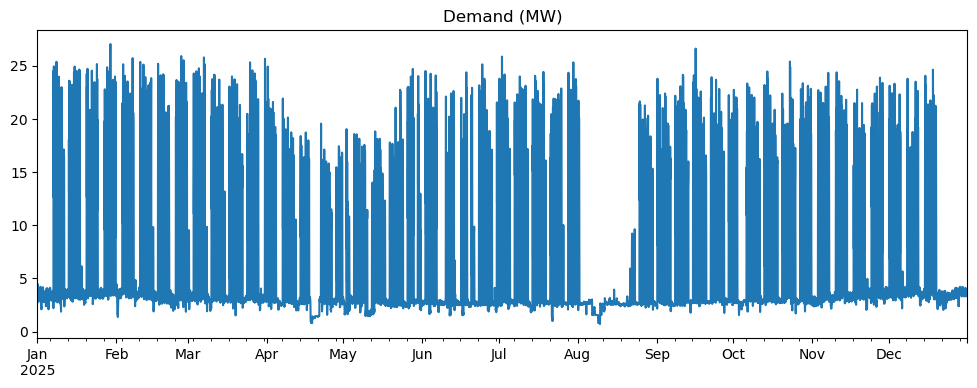

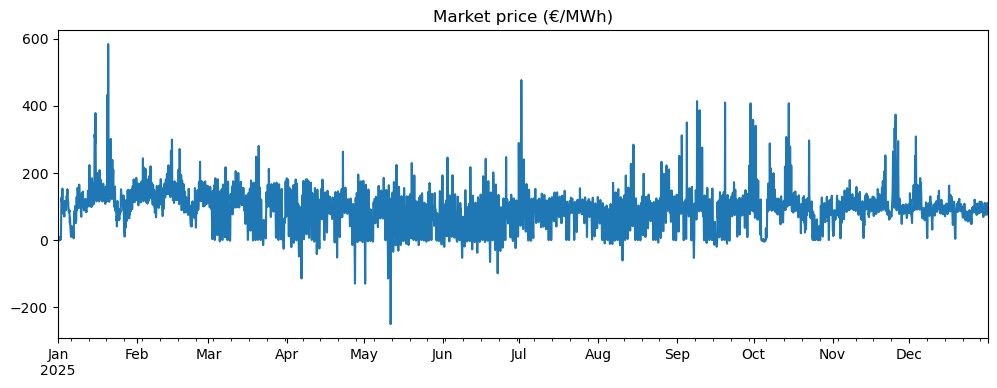

In [10]:
# --- Build model series / setting snapshots ---
#demand_mw = (df_load["load_kw"] / 1000).rename("demand_mw")
demand_mw = (df_load["load_kw"] / 1000 * 100).rename("demand_mw") #for "large company"


snapshots = demand_mw.index

# --- Optional quick sanity plots ---
demand_mw.plot(title="Demand (MW)", figsize=(12,4))
plt.show()

price_eur_per_mwh.plot(title="Market price (€/MWh)", figsize=(12,4))
plt.show()

# Building PyPSA Network:

In [11]:
n = pypsa.Network()
n.set_snapshots(snapshots)

# Carriers (optional, but avoids warnings and keeps things tidy)
n.add("Carrier", "electricity")

# Buses
n.add("Bus", "site", carrier="electricity")
n.add("Bus", "battery", carrier="electricity")

# Consumer demand
n.add("Load", "consumer", bus="site", p_set=demand_mw)

# Grid import only (no export in this MVP)
# p_nom_extendable=True means grid connection capacity could expand.
# If you want a fixed grid limit later, set p_nom=... and p_nom_extendable=False.
n.add(
    "Generator",
    "grid_import",
    bus="site",
    p_nom_extendable=True,
    marginal_cost=price_eur_per_mwh,  # €/MWh
    carrier="electricity",
)


# Battery parameters
eta_charge = 0.95
eta_discharge = 0.95

# These "capital_cost" values should be ANNUALIZED €/MW-year and €/MWh-year for an annual model.
# For a short demo horizon (1 week), the battery will look too expensive unless we scale capex.
# We'll handle scaling in the next cell.
capex_power_eur_per_mw_year = 30000   # placeholder
capex_energy_eur_per_mwh_year = 7500 # placeholder

# Battery energy capacity (MWh)
n.add(
    "Store",
    "bess_energy",
    bus="battery",
    e_nom_extendable=True,
    e_cyclic=True,  # end SOC = start SOC
    capital_cost=capex_energy_eur_per_mwh_year,
    carrier="electricity",
)

# Charger (power capacity MW)
n.add(
    "Link",
    "bess_charger",
    bus0="site",
    bus1="battery",
    p_nom_extendable=True,
    efficiency=eta_charge,
    capital_cost=capex_power_eur_per_mw_year,
    carrier="electricity",
)

# Discharger (power capacity MW)
n.add(
    "Link",
    "bess_discharger",
    bus0="battery",
    bus1="site",
    p_nom_extendable=True,
    efficiency=eta_discharge,
    capital_cost=capex_power_eur_per_mw_year,
    carrier="electricity",
)

# Scale Capex to Model time horizon (in case its smaller than a year):
hours_modelled = len(snapshots) * (snapshots[1] - snapshots[0]).total_seconds() / 3600
fraction_of_year = hours_modelled / 8760

# Scale capex to match the model horizon (development convenience)
n.stores.loc["bess_energy", "capital_cost"] *= fraction_of_year
n.links.loc[["bess_charger", "bess_discharger"], "capital_cost"] *= fraction_of_year

# Solve Network

In [12]:
# Solve

n.optimize(
    solver_name="gurobi",
    solver_options={"LogToConsole": 0}
)

print("Solved. Objective:", n.objective)

C:\Users\finla\AppData\Local\Temp\ipykernel_2832\807920911.py:3: FutureWarning:

The default value of `include_objective_constant` will change from True to False in version 2.0. Set `include_objective_constant` explicitly to suppress this warning. Using False improves LP numerical conditioning by not including the objective constant as a variable.

INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - log_to_console: True
 - LogToConsole: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 233.13it/s]
INFO:linopy.io: Writing time: 0.14s


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2755293


INFO:gurobipy:Set parameter LicenseID to value 2755293


Academic license - for non-commercial use only - expires 2026-12-15


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-12-15


Read LP format model from file C:\Users\finla\AppData\Local\Temp\linopy-problem-8z7klfin.lp


INFO:gurobipy:Read LP format model from file C:\Users\finla\AppData\Local\Temp\linopy-problem-8z7klfin.lp


Reading time = 0.08 seconds


INFO:gurobipy:Reading time = 0.08 seconds


obj: 96364 rows, 43804 columns, 183964 nonzeros


INFO:gurobipy:obj: 96364 rows, 43804 columns, 183964 nonzeros


Set parameter LogToConsole to value 1


INFO:gurobipy:Set parameter LogToConsole to value 1


Set parameter LogToConsole to value 0


INFO:gurobipy:Set parameter LogToConsole to value 0
INFO:gurobipy:Gurobi Optimizer version 13.0.1 build v13.0.1rc0 (win64 - Windows 11+.0 (26200.2))
INFO:gurobipy:
INFO:gurobipy:CPU model: AMD Ryzen AI 9 365 w/ Radeon 880M, instruction set [SSE2|AVX|AVX2|AVX512]
INFO:gurobipy:Thread count: 10 physical cores, 20 logical processors, using up to 20 threads
INFO:gurobipy:
INFO:gurobipy:Non-default parameters:
INFO:gurobipy:LogToConsole  0
INFO:gurobipy:
INFO:gurobipy:Optimize a model with 96364 rows, 43804 columns and 183964 nonzeros (Min)
INFO:gurobipy:Model fingerprint: 0x7230f2b7
INFO:gurobipy:Model has 8681 linear objective coefficients
INFO:gurobipy:Coefficient statistics:
INFO:gurobipy:  Matrix range     [9e-01, 1e+00]
INFO:gurobipy:  Objective range  [1e-02, 3e+04]
INFO:gurobipy:  Bounds range     [0e+00, 0e+00]
INFO:gurobipy:  RHS range        [7e-01, 3e+01]
INFO:gurobipy:
INFO:gurobipy:Presolve removed 52564 rows and 8843 columns
INFO:gurobipy:Presolve time: 0.10s
INFO:gurobipy:Pr

Solved. Objective: 4878468.547987934


# Show Results

--- Optimal battery sizing ---
E (MWh):          43.0166
P charge (MW):    7.5468
P discharge (MW): 4.3887
Objective (€):    4,878,468.55


,demand_mw,price_eur_per_mwh,grid_import_mw,charge_mw,discharge_mw,soc_mwh
2025-01-01 00:00:00,3.921667,2.16,3.921667,0.000000,-0.00000,0.0
2025-01-01 01:00:00,3.871750,1.60,3.871750,0.000000,-0.00000,0.0
2025-01-01 02:00:00,3.813250,0.00,3.813250,0.000000,-0.00000,0.0
2025-01-01 03:00:00,4.450000,-0.01,4.900418,4.619668,-4.16925,0.0
2025-01-01 04:00:00,4.396500,-0.01,4.846918,4.619668,-4.16925,0.0


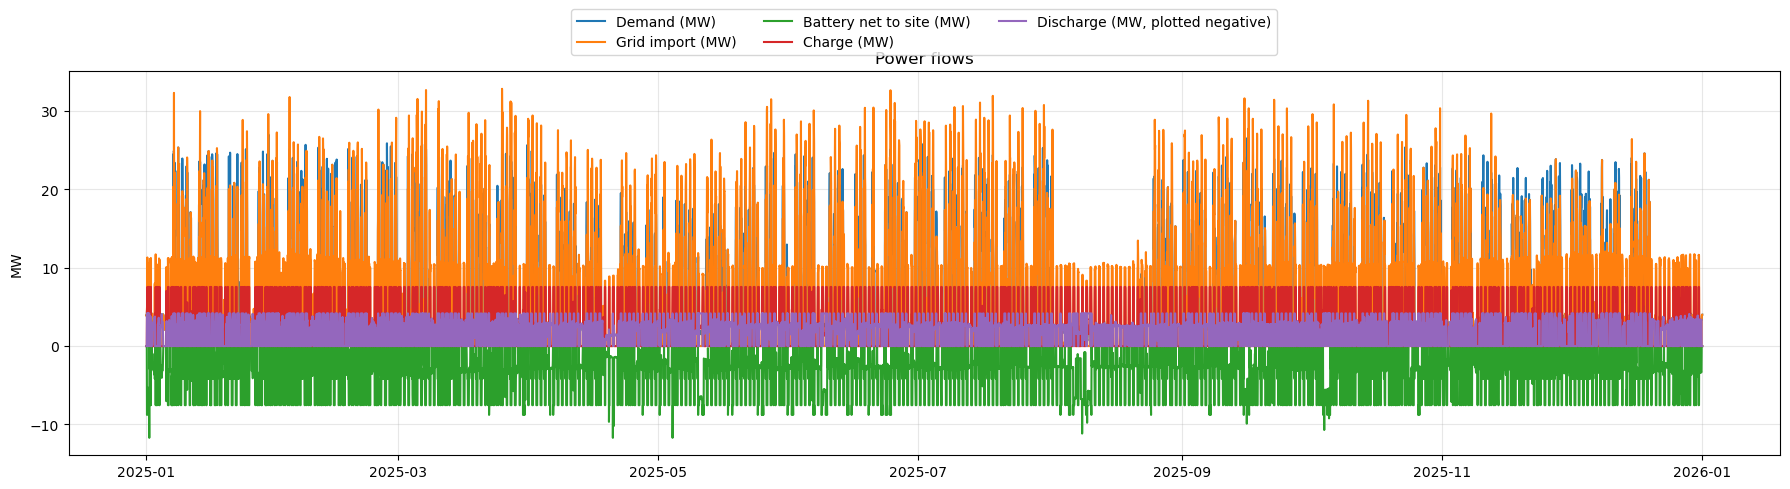

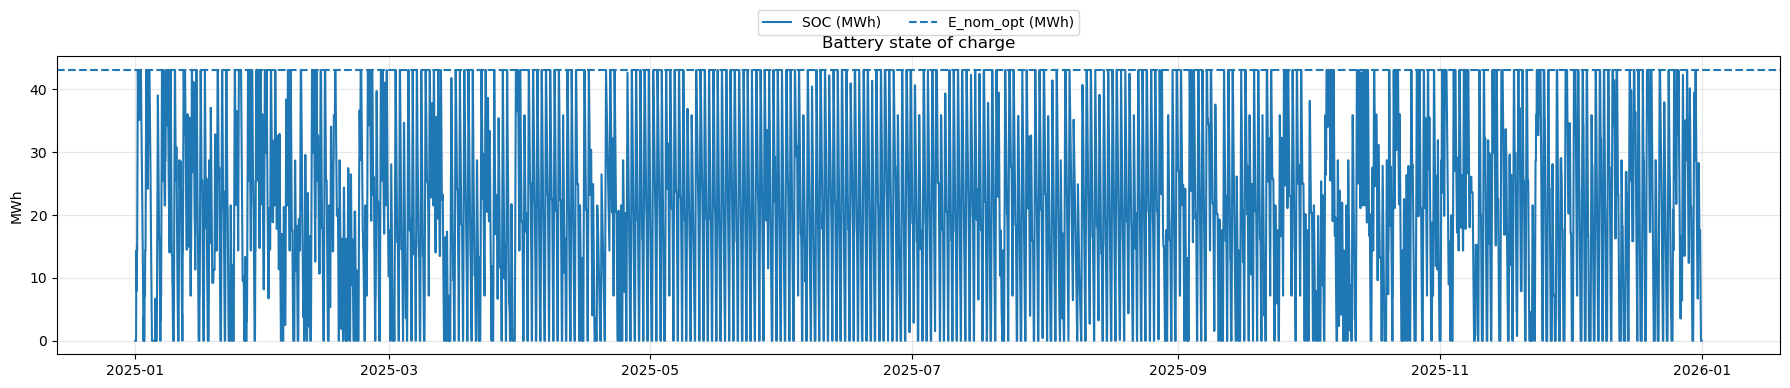

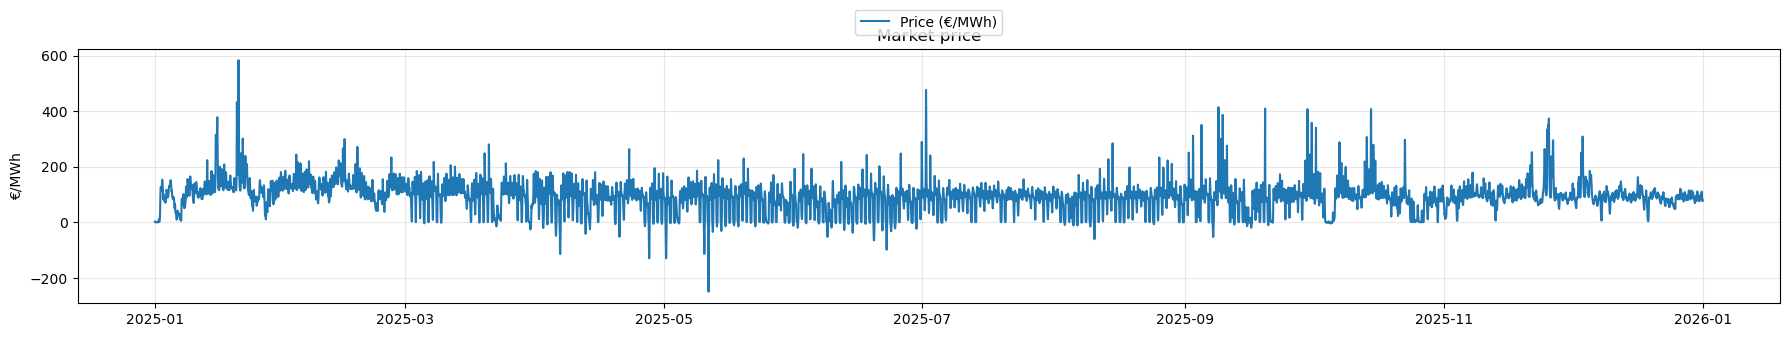

In [13]:
# --- Optimal sizing + objective ---
E_opt = n.stores.at["bess_energy", "e_nom_opt"]          # MWh
P_ch_opt = n.links.at["bess_charger", "p_nom_opt"]       # MW
P_dis_opt = n.links.at["bess_discharger", "p_nom_opt"]   # MW

print("--- Optimal battery sizing ---")
print(f"E (MWh):          {E_opt:.4f}")
print(f"P charge (MW):    {P_ch_opt:.4f}")
print(f"P discharge (MW): {P_dis_opt:.4f}")
print(f"Objective (€):    {n.objective:,.2f}")

# --- Time series ---
soc = n.stores_t.e["bess_energy"]                    # MWh
p_charge = n.links_t.p0["bess_charger"]              # MW drawn from site into charger (>=0)
p_dis = n.links_t.p1["bess_discharger"]              # MW injected into site (>=0)
grid_import = n.generators_t.p["grid_import"]        # MW

df = pd.DataFrame({
    "demand_mw": demand_mw,
    "price_eur_per_mwh": price_eur_per_mwh,
    "grid_import_mw": grid_import,
    "charge_mw": p_charge,
    "discharge_mw": p_dis,
    "soc_mwh": soc,
})

display(df.head())

# =========================
# Nicer, wider visualizations
# =========================
import matplotlib.pyplot as plt

# 1) Power flows (with discharge negative for readability)
plot_df = df[["demand_mw", "grid_import_mw"]].copy()
plot_df["battery_net_mw"] = df["discharge_mw"] - df["charge_mw"]   # + = discharging to site, - = charging
plot_df["charge_mw"] = df["charge_mw"]
plot_df["discharge_mw_neg"] = -df["discharge_mw"]

fig, ax = plt.subplots(figsize=(18, 5))
ax.plot(plot_df.index, plot_df["demand_mw"], label="Demand (MW)")
ax.plot(plot_df.index, plot_df["grid_import_mw"], label="Grid import (MW)")
ax.plot(plot_df.index, plot_df["battery_net_mw"], label="Battery net to site (MW)")

# optional: show charge/discharge separately (discharge negative)
ax.plot(plot_df.index, plot_df["charge_mw"], label="Charge (MW)")
ax.plot(plot_df.index, plot_df["discharge_mw_neg"], label="Discharge (MW, plotted negative)")

ax.set_title("Power flows")
ax.set_ylabel("MW")
ax.grid(True, alpha=0.3)
ax.legend(ncol=3, loc="upper center", bbox_to_anchor=(0.5, 1.18))
plt.tight_layout()
plt.show()

# 2) SOC (with capacity line)
fig, ax = plt.subplots(figsize=(18, 4))
ax.plot(df.index, df["soc_mwh"], label="SOC (MWh)")
ax.axhline(E_opt, linestyle="--", linewidth=1.5, label="E_nom_opt (MWh)")
ax.set_title("Battery state of charge")
ax.set_ylabel("MWh")
ax.grid(True, alpha=0.3)
ax.legend(loc="upper center", bbox_to_anchor=(0.5, 1.18), ncol=2)
plt.tight_layout()
plt.show()

# 3) Price (optional but often useful)
fig, ax = plt.subplots(figsize=(18, 3.5))
ax.plot(df.index, df["price_eur_per_mwh"], label="Price (€/MWh)")
ax.set_title("Market price")
ax.set_ylabel("€/MWh")
ax.grid(True, alpha=0.3)
ax.legend(loc="upper center", bbox_to_anchor=(0.5, 1.18))
plt.tight_layout()
plt.show()

January timesteps: 744


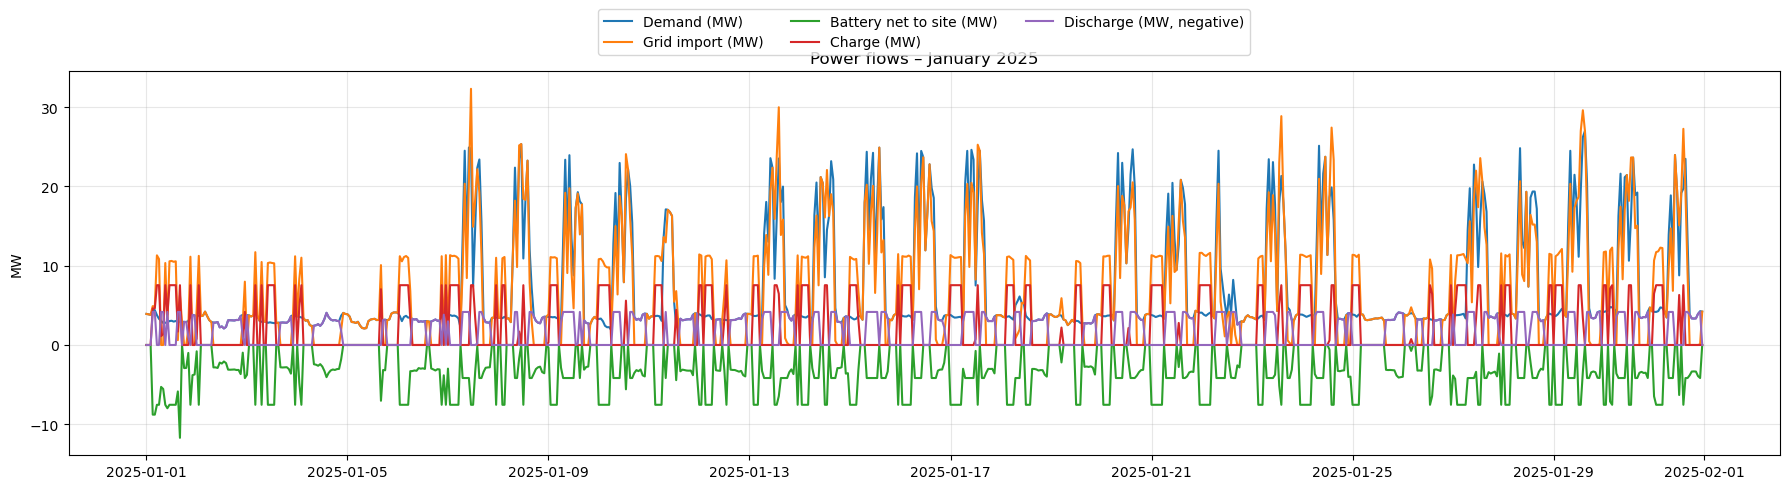

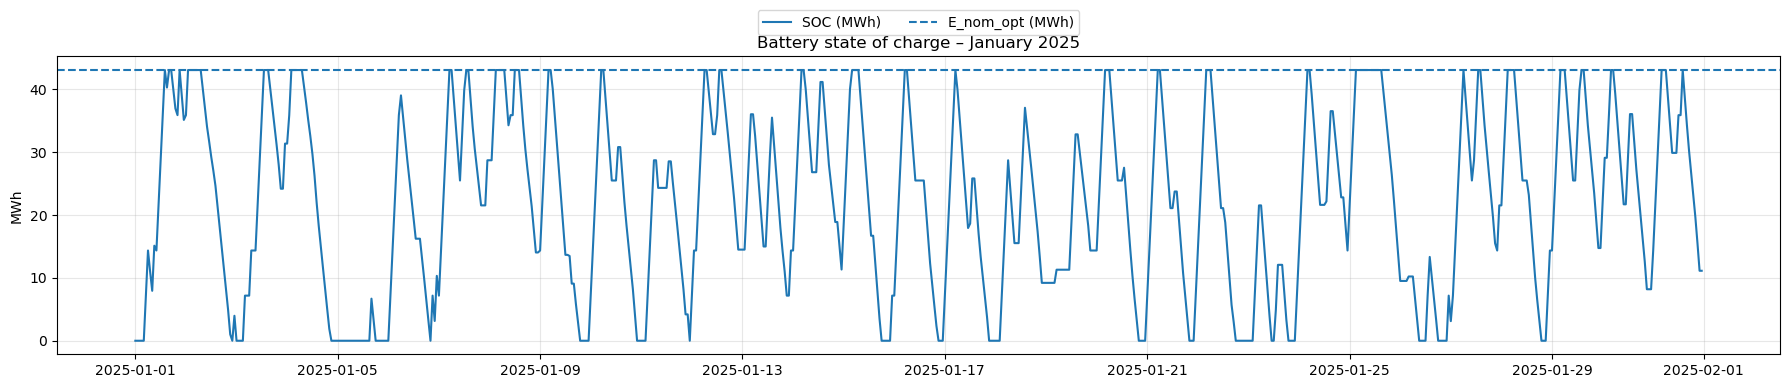

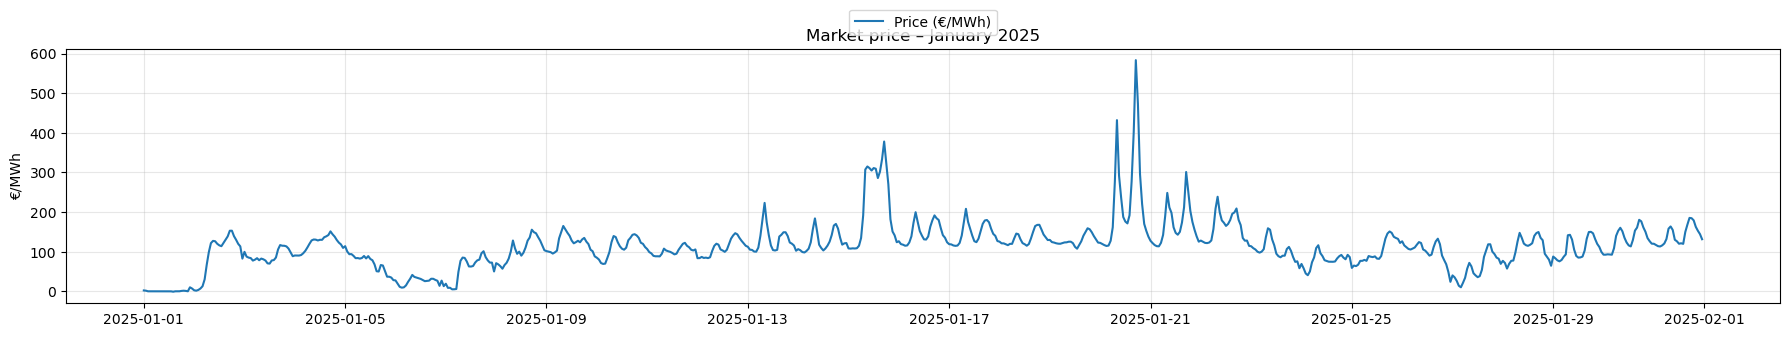

In [14]:
# plotting for january:

# =========================
# Filter January
# =========================

df_jan = df.loc["2025-01-01":"2025-01-31 23:00:00"].copy()

print("January timesteps:", len(df_jan))

# =========================
# 1) Power flows (January)
# =========================

plot_df = df_jan[["demand_mw", "grid_import_mw"]].copy()
plot_df["battery_net_mw"] = df_jan["discharge_mw"] - df_jan["charge_mw"]
plot_df["charge_mw"] = df_jan["charge_mw"]
plot_df["discharge_mw_neg"] = -df_jan["discharge_mw"]

fig, ax = plt.subplots(figsize=(18, 5))

ax.plot(plot_df.index, plot_df["demand_mw"], label="Demand (MW)")
ax.plot(plot_df.index, plot_df["grid_import_mw"], label="Grid import (MW)")
ax.plot(plot_df.index, plot_df["battery_net_mw"], label="Battery net to site (MW)")

ax.plot(plot_df.index, plot_df["charge_mw"], label="Charge (MW)")
ax.plot(plot_df.index, plot_df["discharge_mw_neg"], label="Discharge (MW, negative)")

ax.set_title("Power flows – January 2025")
ax.set_ylabel("MW")
ax.grid(True, alpha=0.3)
ax.legend(ncol=3, loc="upper center", bbox_to_anchor=(0.5, 1.18))

plt.tight_layout()
plt.show()

# =========================
# 2) SOC (January)
# =========================

fig, ax = plt.subplots(figsize=(18, 4))

ax.plot(df_jan.index, df_jan["soc_mwh"], label="SOC (MWh)")
ax.axhline(E_opt, linestyle="--", linewidth=1.5, label="E_nom_opt (MWh)")

ax.set_title("Battery state of charge – January 2025")
ax.set_ylabel("MWh")
ax.grid(True, alpha=0.3)
ax.legend(loc="upper center", bbox_to_anchor=(0.5, 1.18), ncol=2)

plt.tight_layout()
plt.show()

# =========================
# 3) Price (January)
# =========================

fig, ax = plt.subplots(figsize=(18, 3.5))

ax.plot(df_jan.index, df_jan["price_eur_per_mwh"], label="Price (€/MWh)")

ax.set_title("Market price – January 2025")
ax.set_ylabel("€/MWh")
ax.grid(True, alpha=0.3)
ax.legend(loc="upper center", bbox_to_anchor=(0.5, 1.18))

plt.tight_layout()
plt.show()

# Creating / Cleaning Data

In [6]:
import pandas as pd
from pathlib import Path

fp = Path("..") / "Input" / "woodworking_demand_ts_raw.csv"

# 1) Read just the header with delimiter autodetection
df_head = pd.read_csv(fp, sep=None, engine="python", nrows=5, dtype=str)
df_head.columns = df_head.columns.str.replace("\ufeff", "", regex=False).str.strip()
print("Detected columns:", df_head.columns.tolist())

Detected columns: ['Datum', 'Uhrzeit', 'UN_10']


In [14]:
import pandas as pd
from pathlib import Path

fp = Path("..") / "Input" / "woodworking_demand_ts_raw.csv"



df = pd.read_csv(fp, sep=None, engine="python")  # sep=None auto-detects delimiter

# Parse German date + time into a timestamp
df["timestamp"] = pd.to_datetime(
    df["Datum"].astype(str) + " " + df["Uhrzeit"].astype(str),
    dayfirst=True,
    errors="coerce"
)

# Localize (no timezone -> Europe/Berlin) and handle DST ambiguity
ts = df["timestamp"].dt.tz_localize(
    "Europe/Berlin",
    ambiguous="infer",        # or "NaT" if infer fails
    nonexistent="shift_forward"
)

load_kw = pd.to_numeric(df["UN_10"], errors="coerce")
load_kw.index = ts
load_kw.name = "load_kw"

load_kw.head()

timestamp
2014-01-01 00:15:00+01:00    40.69
2014-01-01 00:30:00+01:00    37.52
2014-01-01 00:45:00+01:00    39.44
2014-01-01 01:00:00+01:00    38.80
2014-01-01 01:15:00+01:00    40.05
Name: load_kw, dtype: float64

In [16]:
load_kw_clean = load_kw.copy()

mask_outlier = load_kw_clean > 2000
load_kw_clean.loc[mask_outlier] = np.nan

# replace NaNs (outliers) by previous value
load_kw_clean = load_kw_clean.ffill()

print("Outliers replaced:", int(mask_outlier.sum()))

Outliers replaced: 9894


In [17]:
freq = "15min"

# 1) dedupe (DST)
load_kw_clean = load_kw_clean.sort_index()
load_kw_clean = load_kw_clean.groupby(level=0).mean()

# 2) build full-year index (based on start timestamp)
start = load_kw_clean.index.min()
end = (start + pd.DateOffset(years=1)) - pd.Timedelta(freq)
full_index = pd.date_range(start=start, end=end, freq=freq)

# 3) reindex and fill internal gaps
s = load_kw_clean.reindex(full_index).ffill()

# 4) wrap-fill remaining NaNs (typically at the end)
missing = s.isna()
n_missing = int(missing.sum())
print("Missing points after ffill:", n_missing)

if n_missing > 0:
    donor = s.loc[~s.isna()].iloc[:n_missing].to_numpy()
    s.loc[missing] = donor

print("Any NaNs left?", s.isna().any())

Missing points after ffill: 0
Any NaNs left? False


In [18]:
dup_mask = load_kw_clean.index.duplicated(keep=False)
print("Duplicate timestamp rows:", int(dup_mask.sum()))
display(load_kw_clean[dup_mask].head(20))

Duplicate timestamp rows: 0


Series([], Name: load_kw, dtype: float64)

In [19]:
print("Length (expected 15-min year):", len(s))
print("Any NaNs left?:", s.isna().any())
print("Max kW:", s.max())

Length (expected 15-min year): 35040
Any NaNs left?: False
Max kW: 302.53


In [20]:
s

2014-01-01 00:15:00+01:00    40.69
2014-01-01 00:30:00+01:00    37.52
2014-01-01 00:45:00+01:00    39.44
2014-01-01 01:00:00+01:00    38.80
2014-01-01 01:15:00+01:00    40.05
                             ...  
2014-12-31 23:00:00+01:00    40.77
2014-12-31 23:15:00+01:00    38.85
2014-12-31 23:30:00+01:00    38.77
2014-12-31 23:45:00+01:00    37.17
2015-01-01 00:00:00+01:00    39.33
Freq: 15min, Name: load_kw, Length: 35040, dtype: float64

In [22]:
# s is your cleaned 15-min kW series
load_hourly_kw = s.resample("1h").mean()

print("Length hourly:", len(load_hourly_kw))
load_hourly_kw.tail()

Length hourly: 8761


2014-12-31 20:00:00+01:00    33.1725
2014-12-31 21:00:00+01:00    38.5450
2014-12-31 22:00:00+01:00    40.0725
2014-12-31 23:00:00+01:00    38.8900
2015-01-01 00:00:00+01:00    39.3300
Freq: h, Name: load_kw, dtype: float64

In [27]:
load_hourly_kw["timestep"] = range(1, len(load_hourly_kw) + 1)
print("Length hourly:", len(load_hourly_kw))
load_hourly_kw.tail()

Length hourly: 8761


2014-12-31 20:00:00+01:00                                              33.1725
2014-12-31 21:00:00+01:00                                               38.545
2014-12-31 22:00:00+01:00                                              40.0725
2014-12-31 23:00:00+01:00                                                38.89
timestep                     (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...
Name: load_kw, dtype: object

In [29]:
load_hourly_kw.tail

<bound method NDFrame.tail of 2014-01-01 00:00:00+01:00                                            39.216667
2014-01-01 01:00:00+01:00                                              38.7175
2014-01-01 02:00:00+01:00                                              38.1325
2014-01-01 03:00:00+01:00                                                 44.5
2014-01-01 04:00:00+01:00                                               43.965
                                                   ...                        
2014-12-31 20:00:00+01:00                                              33.1725
2014-12-31 21:00:00+01:00                                               38.545
2014-12-31 22:00:00+01:00                                              40.0725
2014-12-31 23:00:00+01:00                                                38.89
timestep                     (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...
Name: load_kw, Length: 8761, dtype: object>

In [31]:
df_load = load_hourly_kw.to_frame(name="load_kw")

In [ ]:
#df_load = df_load.iloc[:-1]


NameError: name 'df_laod' is not defined

In [38]:

df_load["timestep"] = range(1, len(df_load) + 1)
df_load

,load_kw,timestep
2014-01-01 00:00:00+01:00,39.216667,1
2014-01-01 01:00:00+01:00,38.7175,2
2014-01-01 02:00:00+01:00,38.1325,3
2014-01-01 03:00:00+01:00,44.5,4
2014-01-01 04:00:00+01:00,43.965,5
...,...,...
2014-12-31 19:00:00+01:00,33.15,8756
2014-12-31 20:00:00+01:00,33.1725,8757
2014-12-31 21:00:00+01:00,38.545,8758
2014-12-31 22:00:00+01:00,40.0725,8759


from pathlib import Path

output_path = Path("..") / "Input" / "cleaned_load_hourly_2014.csv"

df_load.to_csv(output_path, index=True)

output_pathm

In [16]:
import pandas as pd

file_path = "../Input/Day-ahead_prices_202501010000_202601010000_Hour.csv"

df_price = pd.read_csv(
    file_path,
    sep=";",          # wichtig!
    encoding="utf-8-sig"  # hilft gegen komische BOM/Zeichen
)

print("Shape:", df_price.shape)
print(df_price.columns)
df_price.head()

Shape: (8760, 19)
Index(['Start date', 'End date',
       'Germany/Luxembourg [€/MWh] Calculated resolutions',
       '∅ DE/LU neighbours [€/MWh] Calculated resolutions',
       'Belgium [€/MWh] Calculated resolutions',
       'Denmark 1 [€/MWh] Calculated resolutions',
       'Denmark 2 [€/MWh] Calculated resolutions',
       'France [€/MWh] Calculated resolutions',
       'Netherlands [€/MWh] Calculated resolutions',
       'Norway 2 [€/MWh] Calculated resolutions',
       'Austria [€/MWh] Calculated resolutions',
       'Poland [€/MWh] Calculated resolutions',
       'Sweden 4 [€/MWh] Calculated resolutions',
       'Switzerland [€/MWh] Calculated resolutions',
       'Czech Republic [€/MWh] Calculated resolutions',
       'DE/AT/LU [€/MWh] Calculated resolutions',
       'Northern Italy [€/MWh] Calculated resolutions',
       'Slovenia [€/MWh] Calculated resolutions',
       'Hungary [€/MWh] Calculated resolutions'],
      dtype='str')


,Start date,End date,Germany/Luxembourg [€/MWh] Calculated resolutions,∅ DE/LU neighbours [€/MWh] Calculated resolutions,Belgium [€/MWh] Calculated resolutions,Denmark 1 [€/MWh] Calculated resolutions,Denmark 2 [€/MWh] Calculated resolutions,France [€/MWh] Calculated resolutions,Netherlands [€/MWh] Calculated resolutions,Norway 2 [€/MWh] Calculated resolutions,Austria [€/MWh] Calculated resolutions,Poland [€/MWh] Calculated resolutions,Sweden 4 [€/MWh] Calculated resolutions,Switzerland [€/MWh] Calculated resolutions,Czech Republic [€/MWh] Calculated resolutions,DE/AT/LU [€/MWh] Calculated resolutions,Northern Italy [€/MWh] Calculated resolutions,Slovenia [€/MWh] Calculated resolutions,Hungary [€/MWh] Calculated resolutions
0,"Jan 1, 2025 12:00 AM","Jan 1, 2025 1:00 AM",2.16,27.99,10.62,2.16,2.54,12.36,13.62,16.35,109.00,15.41,2.67,102.20,21.00,-,138.70,118.46,147.25
1,"Jan 1, 2025 1:00 AM","Jan 1, 2025 2:00 AM",1.60,29.36,10.27,1.60,1.93,18.92,6.24,14.05,97.03,2.19,2.04,98.20,70.50,-,134.06,129.07,126.12
2,"Jan 1, 2025 2:00 AM","Jan 1, 2025 3:00 AM",0.00,25.86,8.38,1.63,1.93,16.66,4.16,12.39,91.47,2.18,2.04,72.60,71.07,-,134.41,121.10,116.50
3,"Jan 1, 2025 3:00 AM","Jan 1, 2025 4:00 AM",-0.01,22.10,6.61,1.09,1.43,13.10,3.28,13.21,72.87,1.69,1.54,67.85,60.45,-,131.99,94.28,71.49
4,"Jan 1, 2025 4:00 AM","Jan 1, 2025 5:00 AM",-0.01,20.38,2.29,0.47,1.04,5.90,0.68,12.23,77.42,0.09,1.18,62.87,60.01,-,131.99,63.69,68.66


In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

col_de = "Germany/Luxembourg [€/MWh] Calculated resolutions"

# Zeitspalten parsen
df_price["Start date"] = pd.to_datetime(df_price["Start date"], errors="coerce")
df_price["End date"]   = pd.to_datetime(df_price["End date"], errors="coerce")

# Index setzen, sortieren, Duplikate raus
df_price = df_price.set_index("Start date").sort_index()
df_price = df_price[~df_price.index.duplicated(keep="first")]

# Preise als float (SMARD hat hier Punkte, aber robust bleiben)
price_eur_per_mwh = pd.to_numeric(df_price[col_de], errors="coerce")
price_eur_per_mwh.name = "price_eur_per_mwh"

print("Price series length:", len(price_eur_per_mwh))
print("NaNs:", price_eur_per_mwh.isna().sum())
price_eur_per_mwh.head()

C:\Users\finla\AppData\Local\Temp\ipykernel_17344\2652201819.py:8: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



Price series length: 8759
NaNs: 0


Start date
2025-01-01 00:00:00    2.16
2025-01-01 01:00:00    1.60
2025-01-01 02:00:00    0.00
2025-01-01 03:00:00   -0.01
2025-01-01 04:00:00   -0.01
Name: price_eur_per_mwh, dtype: float64

In [18]:
price_eur_per_mwh

Start date
2025-01-01 00:00:00     2.16
2025-01-01 01:00:00     1.60
2025-01-01 02:00:00     0.00
2025-01-01 03:00:00    -0.01
2025-01-01 04:00:00    -0.01
                       ...  
2025-12-31 19:00:00    95.99
2025-12-31 20:00:00    86.80
2025-12-31 21:00:00    79.80
2025-12-31 22:00:00    81.39
2025-12-31 23:00:00    76.45
Name: price_eur_per_mwh, Length: 8759, dtype: float64

In [19]:
print("Start:", price_eur_per_mwh.index.min())
print("End:", price_eur_per_mwh.index.max())
print(price_eur_per_mwh.index.to_series().diff().value_counts().head())

Start: 2025-01-01 00:00:00
End: 2025-12-31 23:00:00
Start date
0 days 01:00:00    8757
0 days 02:00:00       1
Name: count, dtype: int64


count    8759.000000
mean       89.331879
std        52.096194
min      -250.320000
25%        71.100000
50%        92.430000
75%       114.145000
max       583.400000
Name: price_eur_per_mwh, dtype: float64

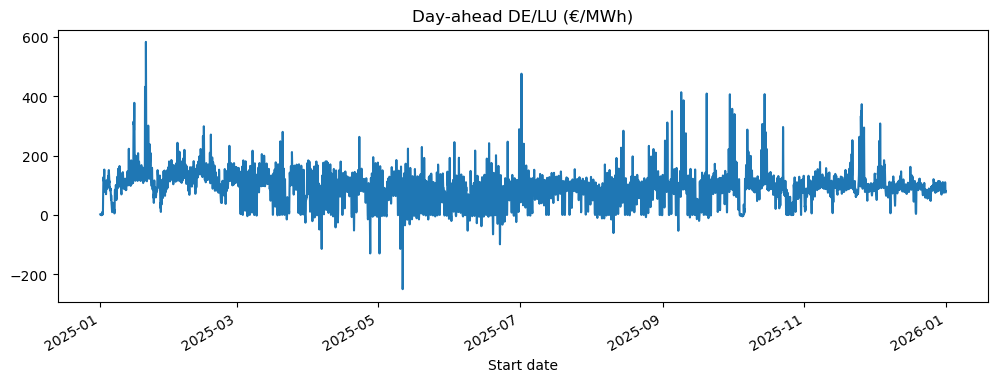

In [20]:
display(price_eur_per_mwh.describe())

price_eur_per_mwh.plot(figsize=(12,4), title="Day-ahead DE/LU (€/MWh)")
plt.show()

In [27]:
# create the full expected hourly index
expected_index = pd.date_range(
    start="2025-01-01 00:00:00",
    end="2025-12-31 23:00:00",
    freq="h"
)

print("Expected hours:", len(expected_index))
print("Actual hours:", len(price_eur_per_mwh))

missing = expected_index.difference(price_eur_per_mwh.index)
print("Missing timestamps:", missing)

Expected hours: 8760
Actual hours: 8760
Missing timestamps: DatetimeIndex([], dtype='datetime64[us]', freq='h')


In [25]:
expected_index = pd.date_range(
    start="2025-01-01 00:00:00",
    end="2025-12-31 23:00:00",
    freq="h"
)

price_eur_per_mwh = price_eur_per_mwh.reindex(expected_index)

print("NaNs after reindex:", price_eur_per_mwh.isna().sum())

NaNs after reindex: 1


In [26]:
price_eur_per_mwh = price_eur_per_mwh.interpolate()

print("Final length:", len(price_eur_per_mwh))
print("NaNs:", price_eur_per_mwh.isna().sum())

Final length: 8760
NaNs: 0


In [28]:
price_eur_per_mwh

2025-01-01 00:00:00     2.16
2025-01-01 01:00:00     1.60
2025-01-01 02:00:00     0.00
2025-01-01 03:00:00    -0.01
2025-01-01 04:00:00    -0.01
                       ...  
2025-12-31 19:00:00    95.99
2025-12-31 20:00:00    86.80
2025-12-31 21:00:00    79.80
2025-12-31 22:00:00    81.39
2025-12-31 23:00:00    76.45
Freq: h, Name: price_eur_per_mwh, Length: 8760, dtype: float64

output_path = "../Input/day_ahead_prices_germany_2025.csv"

price_eur_per_mwh.to_csv(output_path, index=True)

print("Saved to:", output_path)

In [36]:
df_load

,load_kw,timestep
2013-12-31 23:00:00,39.216667,1
2014-01-01 00:00:00,38.717500,2
2014-01-01 01:00:00,38.132500,3
2014-01-01 02:00:00,44.500000,4
2014-01-01 03:00:00,43.965000,5
...,...,...
2014-12-31 18:00:00,33.150000,8756
2014-12-31 19:00:00,33.172500,8757
2014-12-31 20:00:00,38.545000,8758
2014-12-31 21:00:00,40.072500,8759


In [37]:
print("Load length:", len(df_load))
print("Price length:", len(price_eur_per_mwh))

Load length: 8760
Price length: 8760


In [39]:
df_load = df_load.sort_index()  # ensure chronological order
df_load.index = price_index_2025

In [40]:
print(df_load.head())
print(df_load.tail())

print("Load start:", df_load.index.min())
print("Load end:", df_load.index.max())

                       load_kw  timestep
2025-01-01 00:00:00  39.216667         1
2025-01-01 01:00:00  38.717500         2
2025-01-01 02:00:00  38.132500         3
2025-01-01 03:00:00  44.500000         4
2025-01-01 04:00:00  43.965000         5
                     load_kw  timestep
2025-12-31 19:00:00  33.1500      8756
2025-12-31 20:00:00  33.1725      8757
2025-12-31 21:00:00  38.5450      8758
2025-12-31 22:00:00  40.0725      8759
2025-12-31 23:00:00  40.0725      8760
Load start: 2025-01-01 00:00:00
Load end: 2025-12-31 23:00:00


output_path = "../Input/hourly_load_2025_company.csv"

df_load.to_csv(output_path, index=True)

print("Saved to:", output_path)

In [38]:
price_index_2025 = price_eur_per_mwh.index